## 1. Dataset Preparation and Load
1. 데이터셋: tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋 사용
2. 데이터 정보 확인: features, 개수 확인
3. input normalization: 각 채널별 최댓값인 255로 정규화

In [2]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [3]:
#1.데이터셋 다운로드 및 준비
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

dataset_name = 'cats_vs_dogs'
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, with_info=True)
ds_train, ds_info_train = tfds.load('cats_vs_dogs',split='train[:80%]',as_supervised=True, with_info=True)
ds_test, ds_info_test = tfds.load('cats_vs_dogs',split='train[80%:]',as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.ZHYCS9_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


에러확인 후, 왜 에러가 발생했는지에 대해서 찾다가 아이펠에서 준 힌트를 확인.

발생한 에러가 Download error라면, Tensorflow에서 api내에 제공되어있는 링크를 교체한 후 업데이트를 하지 않아 발생한 문제입니다. 데이터를 로드하기 전에, 다음과 같이 변수를 조작하여 새 링크를 반영할 수 있습니다.

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

새 링크의 데이터셋 폴더 구조는 여러분들이 사용하셨던 CIFAR-10과는 다르게, 학습 세트가 구분되어 있지 않습니다. 학습을 잘 해내기 위해서는, 용도에 따라 데이터셋을 나누어야 하겠군요!

API 에러이지만 겁먹지 말자구요! 스스로 해결해야 할 때도 있으니까요.

In [4]:
#2. 데이터의 정보 확인
print(ds_info_train.features)
print(ds_info_test.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

ds_info_train.features["label"].names

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


['cat', 'dog']

In [5]:
#3. 입력 정규화

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

ds_info_train.features["label"].num_classes




2

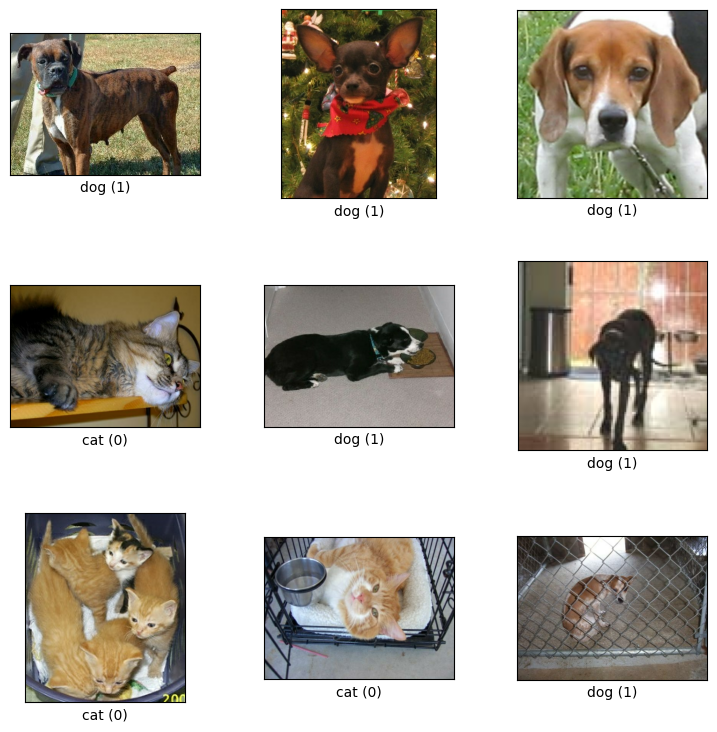

In [6]:
# 학습 및 훈련할 데이터 그림
fig = tfds.show_examples(ds_train, ds_info_train)

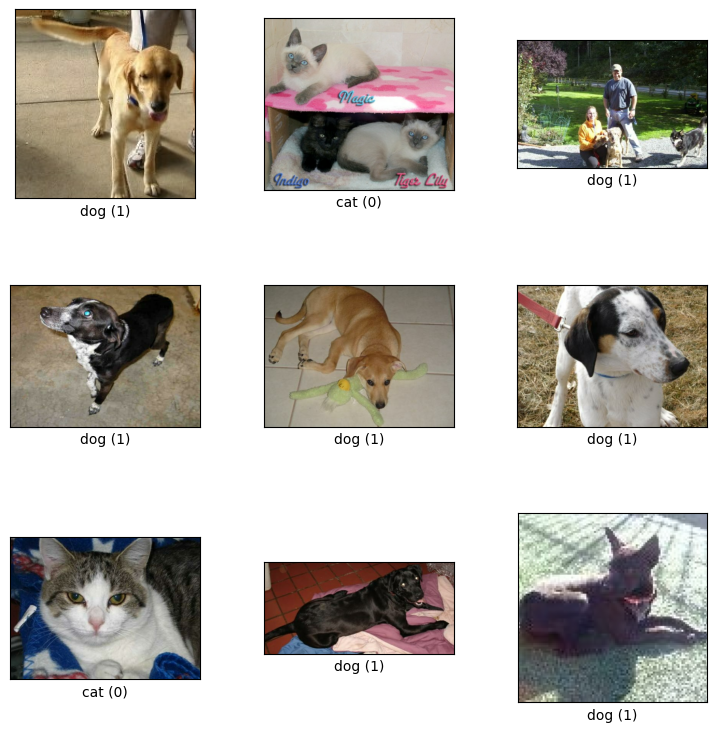

In [7]:
# 학습 및 훈련이 된 데이터의 성능을 테스트할 데이터 그림
fig = tfds.show_examples(ds_test, ds_info_test)

## 2. Dataset Preparation and Load

1. Res-Net 34
2. Res-Net 50
3. Plain 34
4. Plain 50

In [8]:


res_input_layer = keras.layers.Input(shape=(224,224,3))

# resnet_34
def resnet_34(input_layer):
    x = input_layer

    # conv1
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    shortcut = x

    # conv2
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # conv3
    shortcut = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(128,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # conv4
    shortcut = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(256,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # conv5
    shortcut = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(512,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model

resnet_34(res_input_layer).summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_4[0][0]  

 Total params: 21,311,234 (81.30 MB)

 Trainable params: 21,294,210 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [9]:
# resnet_50
def resnet_50(input_layer):
    x = input_layer

    # conv1
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)


    shortcut = keras.layers.Conv2D(256,(1,1), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
#     print(shortcut)
#     print(x)


    # conv2
    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    # conv3
    shortcut = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(shortcut) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)


    # conv4
    shortcut = keras.layers.Conv2D(1024,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)



    # conv5
    shortcut = keras.layers.Conv2D(2048,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model

resnet_50(res_input_layer).summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 115, 115,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 115, 115,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 115, 115,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 117, 117,  │          0 │ activation_33[0]… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 58, 58,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 58, 58,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 58, 58,    │     36,928 │ activation_34[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 58, 58,    │     16,640 │ activation_35[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 58, 58,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │      1,024 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │      1,024 │ conv2d_37[0][0] 

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
#plain-34 (skip connection ablation)
def plain_34(input_layer):

    x = input_layer

    # conv1
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)

    # conv2
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv3
    x = keras.layers.Conv2D(128,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv4

    x = keras.layers.Conv2D(256,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv5

    x = keras.layers.Conv2D(512,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)


    model = keras.Model(inputs = input_layer, outputs = x)
    return model

plain_34(res_input_layer).summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_85 (Activation)      │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_86 (Activation)      │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_87 (Activation)      │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 55, 55, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 55, 55, 64)     │           25

 Total params: 21,134,722 (80.62 MB)

 Trainable params: 21,119,490 (80.56 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [11]:
#plain-50 (skip connection ablation)

def plain_50(input_layer):
    x = input_layer

    # conv1
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)

    # conv2
    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    # conv3
    x = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv4
    x = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    # conv5
    x = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model
plain_50(res_input_layer).summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 230, 230, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 115, 115, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 115, 115, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_115 (Activation)     │ (None, 115, 115, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 117, 117, 64)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 58, 58, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 58, 58, 256)    │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 58, 58, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_118 (Activation)     │ (None, 58, 58, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 58, 58, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_119 (Activation)     │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,803,714 (79.36 MB)

 Trainable params: 20,758,274 (79.19 MB)

 Non-trainable params: 45,440 (177.50 KB)

## 3. Training

In [12]:
BatchSize = 16
Epoch = 20

In [13]:
input_layer = keras.layers.Input(shape=(224,224,3))

model_res_34 = resnet_34(input_layer)
model_res_50 = resnet_50(input_layer)
model_plain_34 = plain_34(input_layer)
model_plain_50 = plain_50(input_layer)

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BatchSize)

In [15]:
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BatchSize)

In [16]:
h_resnet_34 = [
[0.7183, 0.5929, 1.7381, 0.5209],
[0.6112, 0.6678, 0.9815, 0.5613],
[0.5610, 0.7187, 0.7899, 0.6420],
[0.4943, 0.7606, 0.9503, 0.5744],
[0.4112, 0.8101, 0.5154, 0.7754],
[0.3481, 0.8511, 1.1424, 0.6598],
[0.2612, 0.8903, 0.5718, 0.7927],
[0.1625, 0.9357, 0.5929, 0.8324],
[0.1150, 0.9562, 0.7951, 0.8190],
[0.0672, 0.9750, 1.0594, 0.7791],
[0.0473, 0.9812, 0.6981, 0.8366],
[0.0407, 0.9870, 0.7416, 0.8456],
[0.0205, 0.9929, 0.7807, 0.8462],
[0.0113, 0.9956, 0.8059, 0.8391],
[0.0094, 0.9967, 0.8080, 0.8537],
[0.0072, 0.9972, 0.8489, 0.8606],
[0.0042, 0.9987, 0.8416, 0.8572],
[0.0020, 0.9993, 0.9689, 0.8499],
[0.0025, 0.9994, 0.8263, 0.8654],
[8.9776e-04, 0.9998, 0.8770, 0.8642]
]

history_resnet_34 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}
for i in range(20):
    history_resnet_34['loss'].append(h_resnet_34[i][0])
    history_resnet_34['accuracy'].append(h_resnet_34[i][1])
    history_resnet_34['val_loss'].append(h_resnet_34[i][2])
    history_resnet_34['val_accuracy'].append(h_resnet_34[i][3])

history_resnet_34['loss']

[0.7183,
 0.6112,
 0.561,
 0.4943,
 0.4112,
 0.3481,
 0.2612,
 0.1625,
 0.115,
 0.0672,
 0.0473,
 0.0407,
 0.0205,
 0.0113,
 0.0094,
 0.0072,
 0.0042,
 0.002,
 0.0025,
 0.00089776]

In [17]:
h_resnet_50 = [
[0.6794, 0.6021, 0.8557, 0.5477],
[0.6771, 0.6077, 0.7557, 0.5705],
[0.6599, 0.6270, 0.8560, 0.5699],
[0.6411, 0.6455, 1.0810, 0.5192],
[0.6403, 0.6513, 0.6628, 0.6225],
[0.6229, 0.6623, 1.1846, 0.5631],
[0.6005, 0.6827, 0.5926, 0.6933],
[0.5873, 0.6934, 0.7289, 0.6050],
[0.5813, 0.6928, 0.5821, 0.6935],
[0.5561, 0.7193, 0.6466, 0.7047],
[0.5192, 0.7460, 0.5258, 0.7496],
[0.4910, 0.7651, 0.7099, 0.6578],
[0.4549, 0.7877, 0.5642, 0.7444],
[0.4131, 0.8149, 0.7383, 0.6953],
[0.3699, 0.8345, 0.9301, 0.6534],
[0.3137, 0.8647, 0.6103, 0.7593],
[0.2564, 0.8927, 0.8876, 0.7243],
[0.2036, 0.9182, 0.9631, 0.7274],
[0.1601, 0.9384, 0.9631, 0.7573],
[0.1165, 0.9525, 0.7355, 0.7996]
]

history_resnet_50 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}
for i in range(20):
    history_resnet_50['loss'].append(h_resnet_50[i][0])
    history_resnet_50['accuracy'].append(h_resnet_50[i][1])
    history_resnet_50['val_loss'].append(h_resnet_50[i][2])
    history_resnet_50['val_accuracy'].append(h_resnet_50[i][3])

In [18]:
h_plain_34 = [
    [0.7077, 0.5327, 1.0329, 0.5351],
    [0.6973, 0.5284, 1.1648, 0.5164],
    [0.6598, 0.6054, 0.7900, 0.5384],
    [0.6509, 0.6206, 0.6507, 0.6303],
    [0.6400, 0.6300, 0.6700, 0.6200],
    [0.6315, 0.6392, 0.6963, 0.6111],
    [0.6139, 0.6590, 0.7864, 0.6110],
    [0.5877, 0.6839, 0.6003, 0.6976],
    [0.5535, 0.7150, 0.5412, 0.7317],
    [0.5097, 0.7427, 0.4551, 0.7899],
    [0.4633, 0.7764, 0.5005, 0.7588],
    [0.4136, 0.8151, 0.4044, 0.8149],
    [0.3581, 0.8442, 0.4357, 0.8097],
    [0.3126, 0.8661, 0.4068, 0.8138],
    [0.2725, 0.8884, 0.4083, 0.8252],
    [0.2314, 0.9056, 0.4621, 0.8199],
    [0.1900, 0.9205, 0.4434, 0.8147],
    [0.1501, 0.9411, 0.3356, 0.8760],
    [0.1218, 0.9548, 0.6391, 0.8341],
    [0.0923, 0.9671, 0.4248, 0.8714]
]

history_plain_34 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}
for i in range(20):
    history_plain_34['loss'].append(h_plain_34[i][0])
    history_plain_34['accuracy'].append(h_plain_34[i][1])
    history_plain_34['val_loss'].append(h_plain_34[i][2])
    history_plain_34['val_accuracy'].append(h_plain_34[i][3])

In [19]:
model_plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BatchSize),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BatchSize),
    epochs=Epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'use_multiprocessing'

에러 발생

In [21]:
history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BatchSize),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BatchSize),
    epochs=Epoch,
    validation_data=ds_test,
    verbose=1
)

Epoch 1/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 179s 150ms/step - accuracy: 0.5134 - loss: 0.7078 - val_accuracy: 0.5069 - val_loss: 1.0547
Epoch 2/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 174s 149ms/step - accuracy: 0.5093 - loss: 0.7117 - val_accuracy: 0.5196 - val_loss: 0.7982
Epoch 3/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 200s 172ms/step - accuracy: 0.5156 - loss: 0.7066 - val_accuracy: 0.5024 - val_loss: 0.9130
Epoch 4/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 172s 148ms/step - accuracy: 0.5354 - loss: 0.7024 - val_accuracy: 0.5272 - val_loss: 0.7753
Epoch 5/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 202s 174ms/step - accuracy: 0.5766 - loss: 0.6807 - val_accuracy: 0.5984 - val_loss: 0.7365
Epoch 6/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 172s 148ms/step - accuracy: 0.6018 - loss: 0.6663 - val_accuracy: 0.6270 - val_loss: 0.6491
Epoch 7/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 175s 150ms/step - accuracy: 0.6279 - loss: 0.6451 - val_accuracy: 0.6166 - val_loss: 0.7294
Epoch 8/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 173s 149ms/step - ac

In [22]:
model_plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BatchSize),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BatchSize),
    epochs=Epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'use_multiprocessing'

## 4. Visualization and Test Results

1. ResNet-34 vs. Plain-34
2. ResNet-50 vs. Plain-50


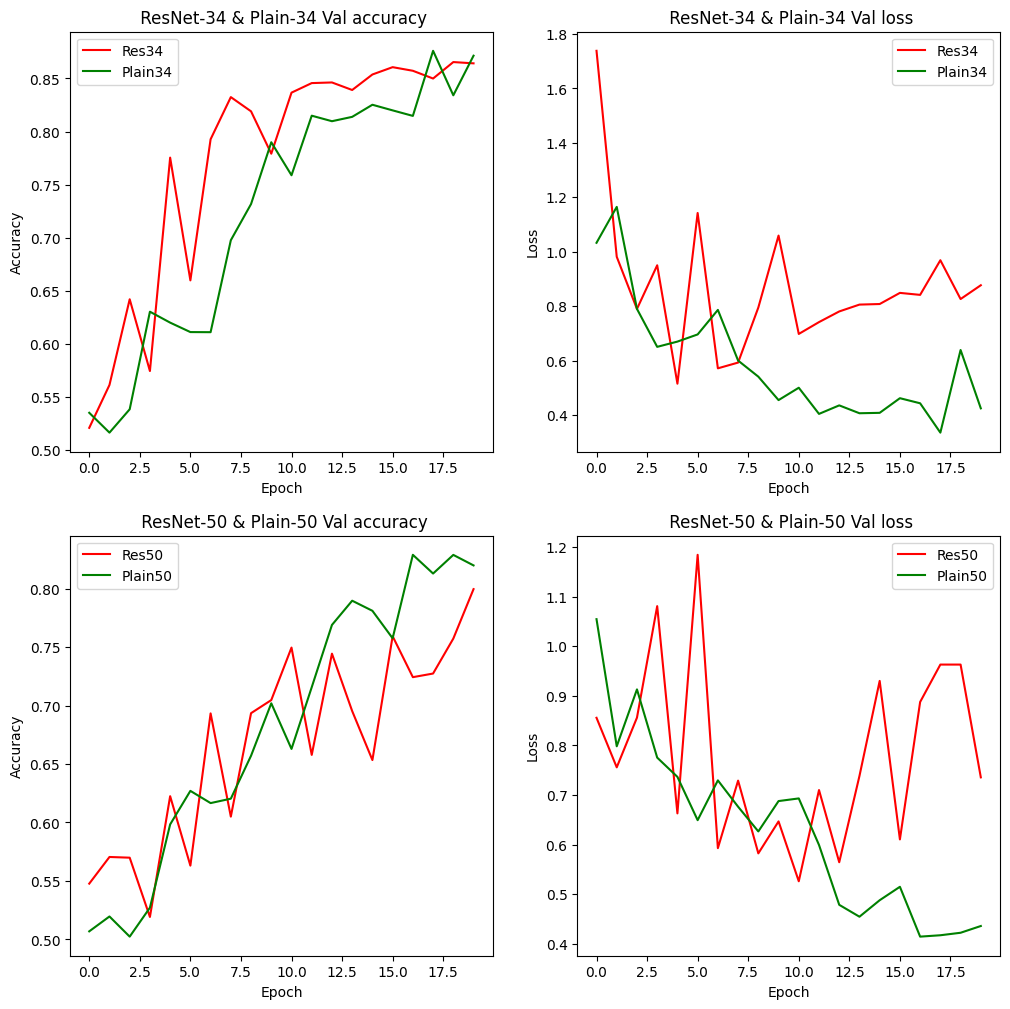

In [23]:

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history_resnet_34['val_accuracy'], 'r')
plt.plot(history_plain_34['val_accuracy'], 'g')
plt.title(' ResNet-34 & Plain-34 Val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 2, 2)
plt.plot(history_resnet_34['val_loss'], 'r')
plt.plot(history_plain_34['val_loss'], 'g')
plt.title(' ResNet-34 & Plain-34 Val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 2, 3)
plt.plot(history_resnet_50['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title(' ResNet-50 & Plain-50 Val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.subplot(2, 2, 4)
plt.plot(history_resnet_50['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title(' ResNet-50 & Plain-50 Val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.show()

## 5. Train Loss and Accuracy

1. ResNet-34 vs. Plain-34
2. ResNet-50 vs. Plain-50

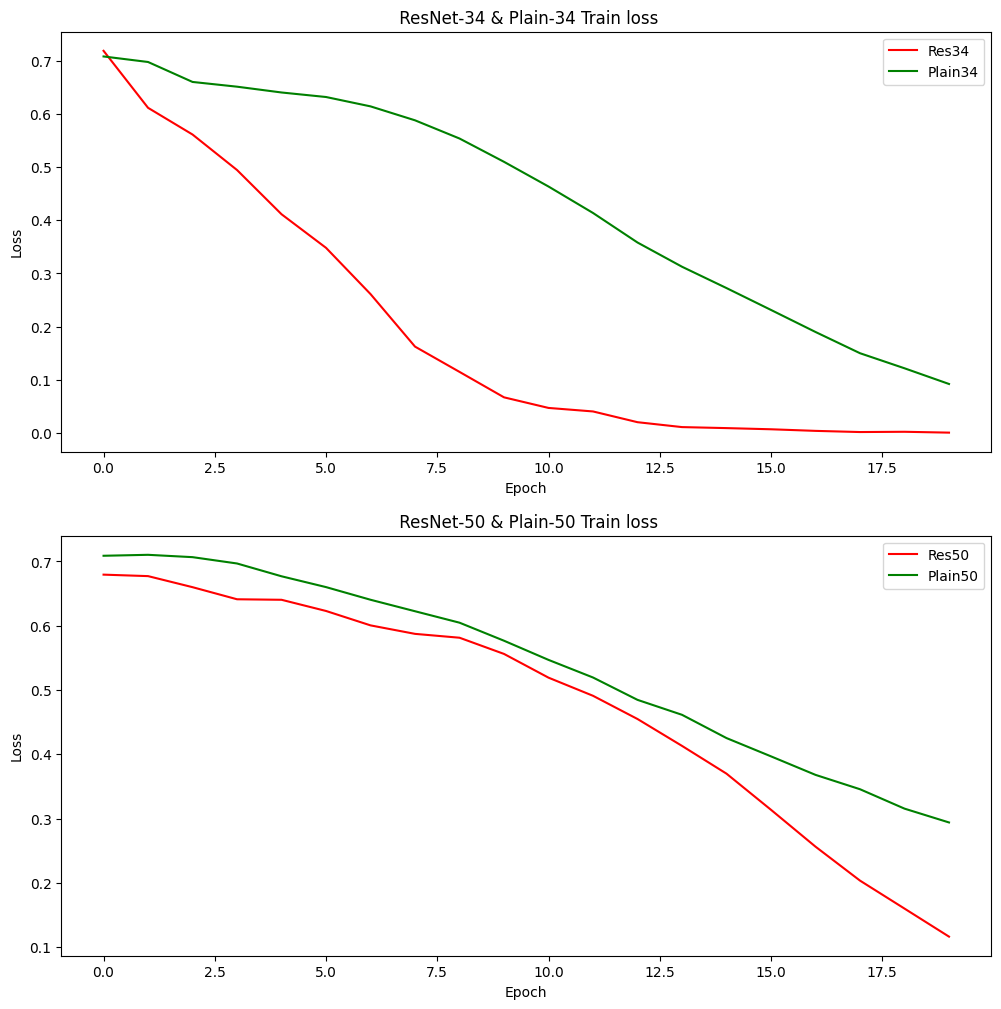

In [24]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['loss'], 'r')
plt.plot(history_plain_34['loss'], 'g')
plt.title(' ResNet-34 & Plain-34 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title(' ResNet-50 & Plain-50 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.show()

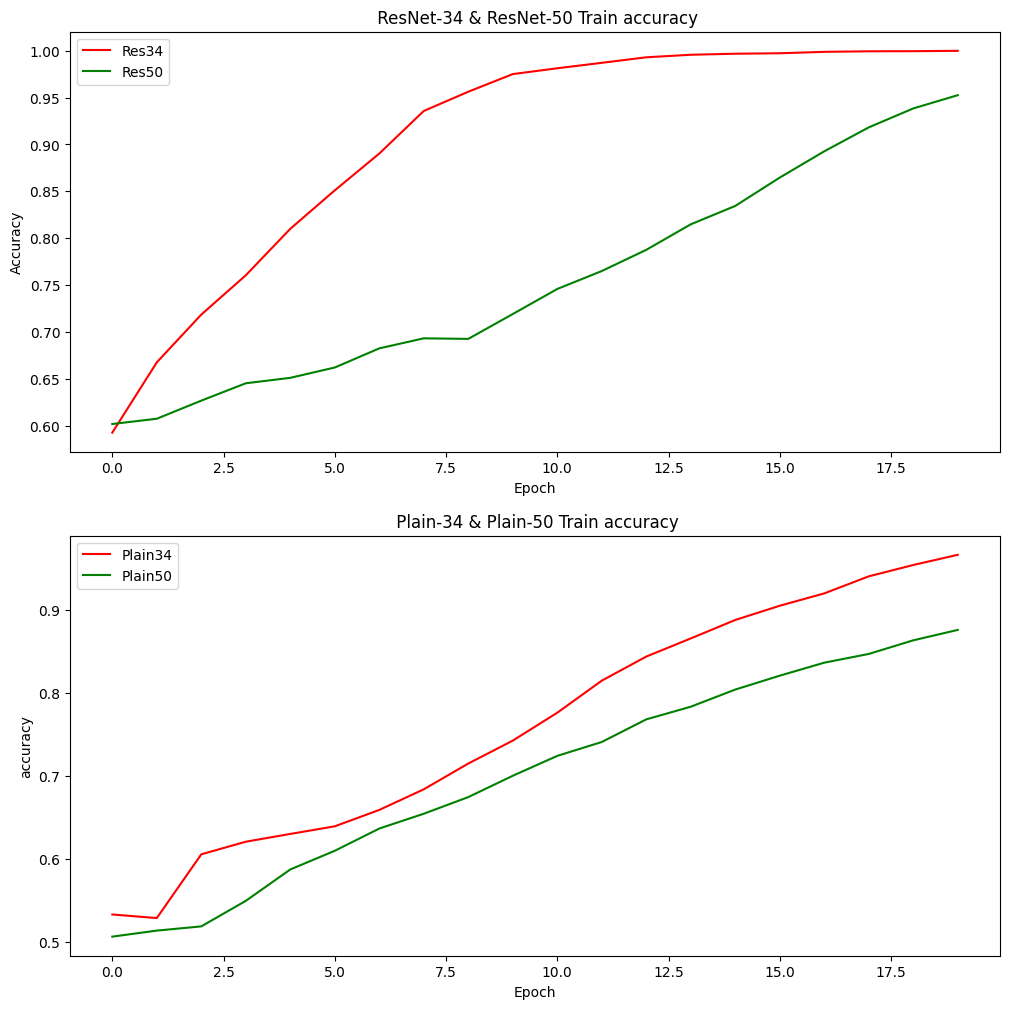

In [25]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['accuracy'], 'r')
plt.plot(history_resnet_50['accuracy'], 'g')
plt.title(' ResNet-34 & ResNet-50 Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Res50'])

plt.subplot(2, 1, 2)
plt.plot(history_plain_34['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title(' Plain-34 & Plain-50 Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain34', 'Plain50'])

plt.show()

##5. Evaluations

루브릭
평가문항	상세기준
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가	블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?	cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?	ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.


##6. 회고 (Reflections)

프로젝트를 하면서 예상치 못한 상황이 발생하여, 미리 준비하지 못한점에 대해서 반성합니다.
환경이 달라질 수 있는 상황을 예측하여 미리 했어얗 했는데,
그 부분을 상정을 안하여 주말에 많은 시간을 썼습니다. 또한 GPU가 얼마나 중요한 역할을 맡아 하는지와 시간을 얼만큼 효율적으로 배분해서 성과를 낼 수 있어야 하는가에 대한 고민도 해볼 수 있었던것 같습니다.